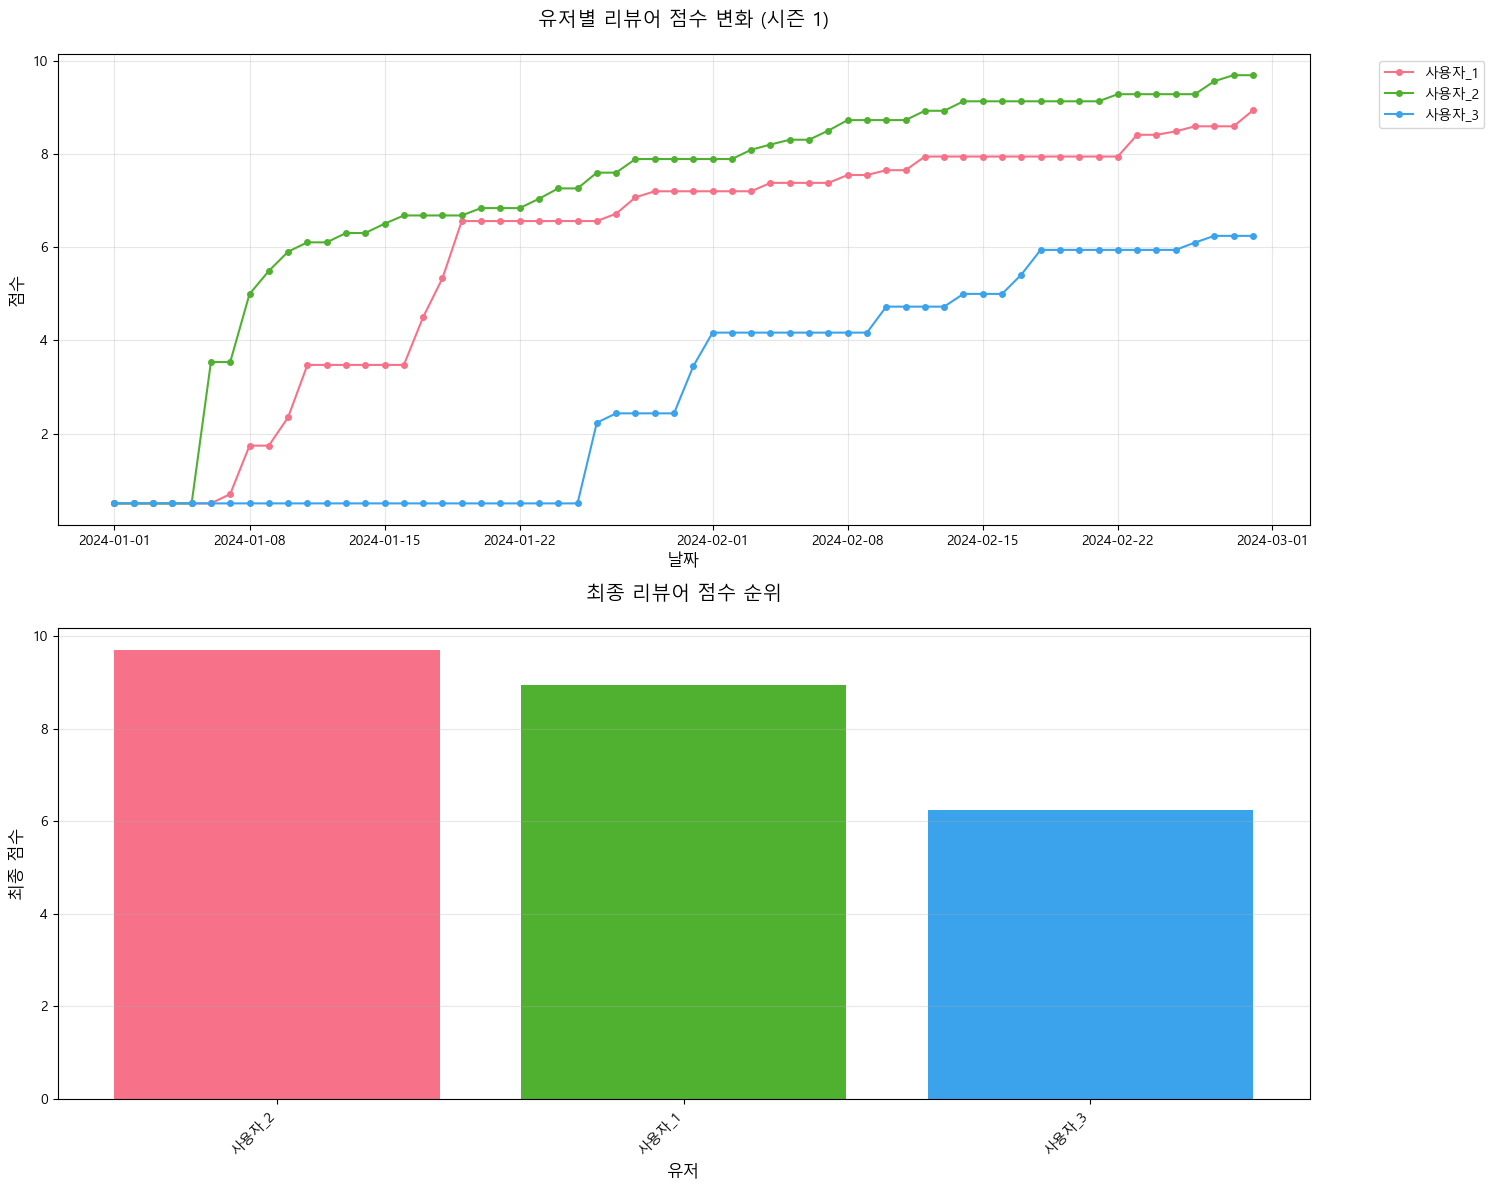


최종 리뷰어 통계:
         누적 리뷰 수  누적 도움됨 수  베스트 리뷰 수  최종 점수
user_id                                    
사용자_2         21        34         5   9.69
사용자_1         22        27         2   8.94
사용자_3         10         6         1   6.24


,누적 리뷰 수,누적 도움됨 수,베스트 리뷰 수,최종 점수
user_id,,,,
사용자_2,21,34,5,9.691912
사용자_1,22,27,2,8.935446
사용자_3,10,6,1,6.242753


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 시뮬레이션을 위한 랜덤 시드 설정
np.random.seed(40)

def generate_user_data(n_users, n_days):
    """n_users에 대한 n_days 동안의 daily 활동 데이터 생성"""
    users = []
    start_date = datetime(2024, 1, 1)
    
    for user_id in range(n_users):
        # 각 유저의 활동성 레벨을 랜덤하게 설정
        activity_level = np.random.uniform(0.3, 1.0)
        
        for day in range(n_days):
            current_date = start_date + timedelta(days=day)
            
            # 날짜가 지날수록 활동이 증가하도록 설정
            day_factor = 1 + (day / n_days) * 0.5
            
            # 일일 리뷰 작성 수 (포아송 분포 사용)
            daily_reviews = np.random.poisson(activity_level * day_factor * 0.5)
            
            # 각 리뷰당 받은 도움 수 (정규분포 사용)
            if daily_reviews > 0:
                helps_per_review = np.random.normal(2 * activity_level * day_factor, 1)
                daily_helps = max(0, int(helps_per_review * daily_reviews))
            else:
                daily_helps = 0
            
            # 베스트 리뷰 선정 (낮은 확률로 발생)
            best_review = 1 if np.random.random() < 0.05 * activity_level else 0
            
            users.append({
                'user_id': f'사용자_{user_id+1}',
                'date': current_date,
                'reviews': daily_reviews,
                'helps': daily_helps,
                'recency': 1.0,  # 당일 리뷰는 최근성 1.0
                'best_reviews': best_review,
                'activity_level': activity_level
            })
    
    return pd.DataFrame(users)

def calculate_score(R, H, T, B, w_R, w_H, w_T, w_B, lambda_T, age):
    """점수 계산 함수"""
    T_score = T * np.exp(-lambda_T * age)
    score = (
        w_R * np.log(1 + R) +
        w_H * np.log(1 + H) +
        w_T * T_score +
        w_B * B
    )
    return score

# 데이터 생성
n_users = 3
n_days = 60
df = generate_user_data(n_users, n_days)

# 누적 데이터 계산
df['cum_reviews'] = df.groupby('user_id')['reviews'].cumsum()
df['cum_helps'] = df.groupby('user_id')['helps'].cumsum()
df['cum_best_reviews'] = df.groupby('user_id')['best_reviews'].cumsum()

# 시즌 1의 가중치로 일일 점수 계산
lambda_T = 0.1
weights = {"w_R": 1.5, "w_H": 1.0, "w_T": 0.5, "w_B": 0.2}

df['score'] = df.apply(lambda row: calculate_score(
    row['cum_reviews'],
    row['cum_helps'],
    row['recency'],
    row['cum_best_reviews'],
    lambda_T=lambda_T,
    age=0,
    **weights
), axis=1)

# 색상 설정
colors = sns.color_palette('husl', n_colors=n_users)

# 시각화
fig = plt.figure(figsize=(15, 12))

# 점수 변화 그래프
plt.subplot(2, 1, 1)
for idx, user in enumerate(df['user_id'].unique()):
    user_data = df[df['user_id'] == user]
    plt.plot(user_data['date'], user_data['score'], 
             marker='o', markersize=4, 
             color=colors[idx], 
             label=user)

plt.title('유저별 리뷰어 점수 변화 (시즌 1)', pad=20, size=14)
plt.xlabel('날짜', size=12)
plt.ylabel('점수', size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 최종 점수 분포
plt.subplot(2, 1, 2)
final_scores = df.groupby('user_id')['score'].last().sort_values(ascending=False)
bars = plt.bar(range(len(final_scores)), final_scores.values, color=colors)
plt.xticks(range(len(final_scores)), final_scores.index, rotation=45, ha='right')
plt.title('최종 리뷰어 점수 순위', pad=20, size=14)
plt.xlabel('유저', size=12)
plt.ylabel('최종 점수', size=12)
plt.grid(True, alpha=0.3, axis='y')

# 레이아웃 조정
plt.tight_layout()
plt.show()

# 통계 데이터 출력을 위한 컬럼명 한글화
final_stats = df.groupby('user_id').agg({
    'cum_reviews': 'last',
    'cum_helps': 'last',
    'cum_best_reviews': 'last',
    'score': 'last'
}).sort_values('score', ascending=False)

final_stats.columns = ['누적 리뷰 수', '누적 도움됨 수', '베스트 리뷰 수', '최종 점수']

print("\n최종 리뷰어 통계:")
print(final_stats.round(2))
pd.DataFrame(final_stats)

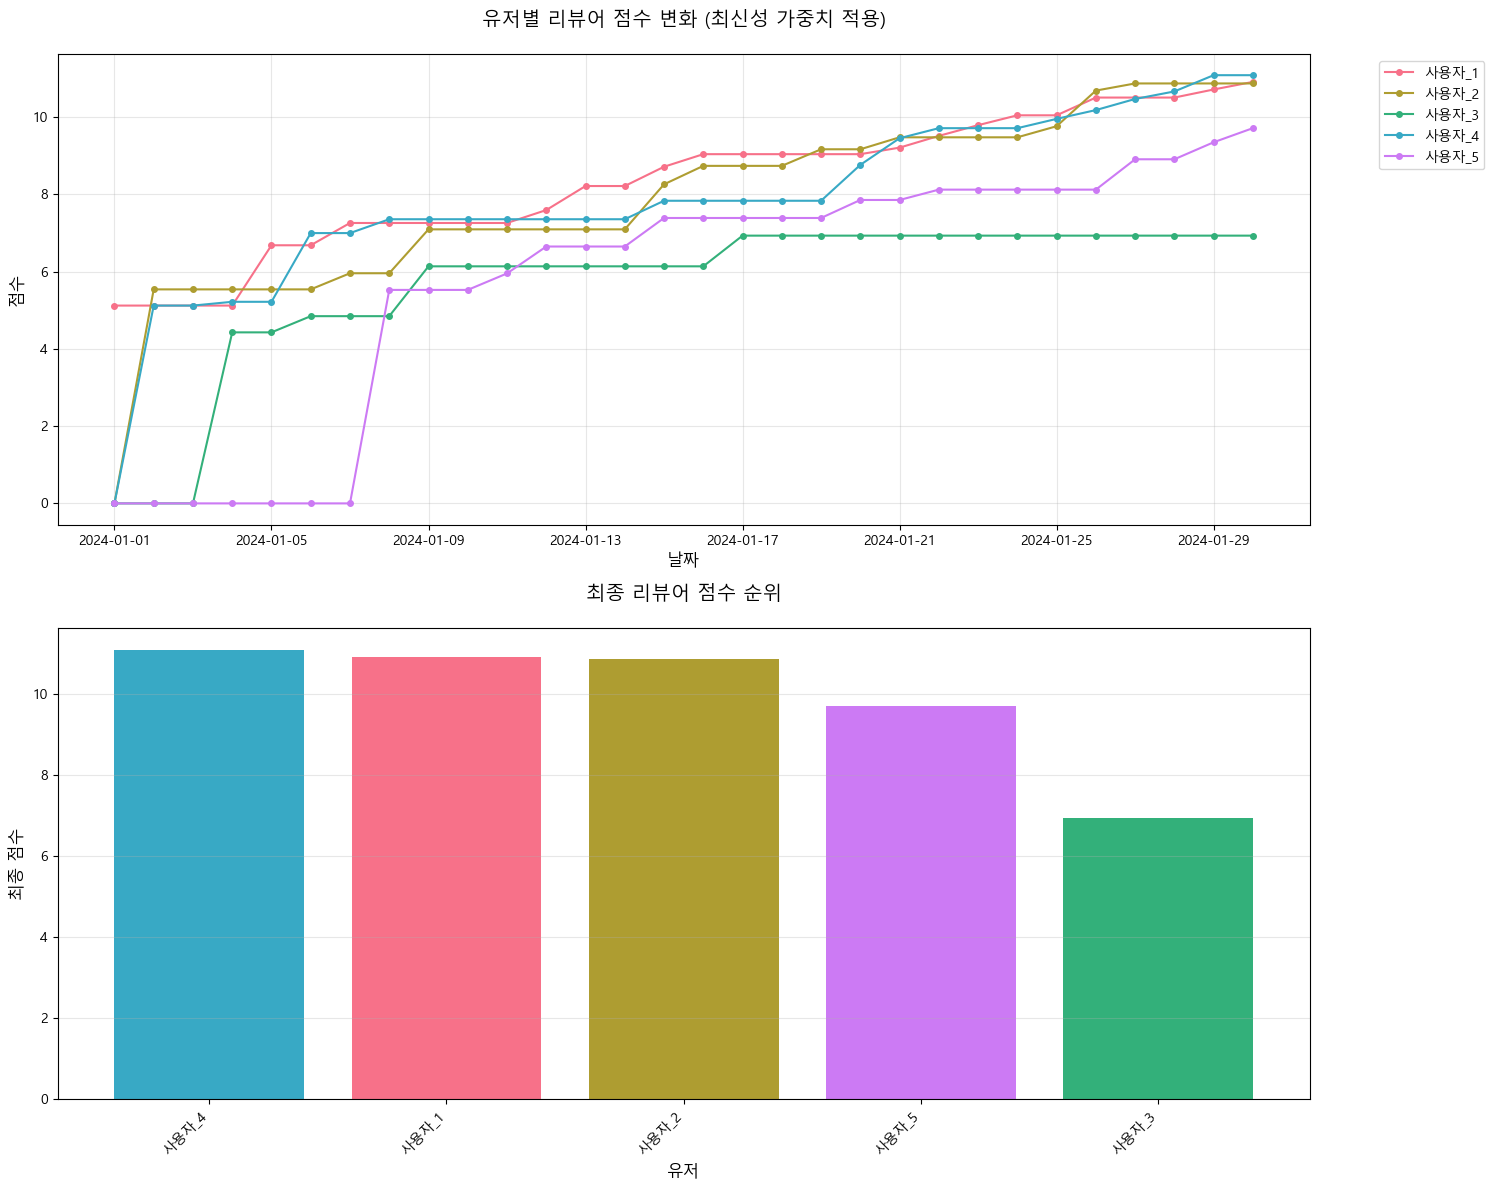


최종 리뷰어 통계:
    user_id  num_reviews  weighted_helps  weighted_best  recency_score  score
148   사용자_4           17            1.32           0.01           0.06  11.08
145   사용자_1           17            0.96           0.00           0.06  10.91
146   사용자_2           16            1.28           0.00           0.06  10.87
149   사용자_5           11            1.30           0.00           0.09   9.71
147   사용자_3            5            0.29           0.00           0.20   6.93


,date,user_id,score,num_reviews,weighted_helps,recency_score,weighted_best
2,2024-01-01,사용자_3,0.000000,0,0.000000,0.000000,0.0
7,2024-01-02,사용자_3,0.000000,0,0.000000,0.000000,0.0
12,2024-01-03,사용자_3,0.000000,0,0.000000,0.000000,0.0
17,2024-01-04,사용자_3,4.426015,1,0.000000,1.000000,0.0
22,2024-01-05,사용자_3,4.426015,1,0.000000,1.000000,0.0
27,2024-01-06,사용자_3,4.845143,2,0.000000,0.500000,0.0
32,2024-01-07,사용자_3,4.845143,2,0.000000,0.500000,0.0
37,2024-01-08,사용자_3,4.845143,2,0.000000,0.500000,0.0
42,2024-01-09,사용자_3,6.134977,3,0.852025,0.333333,0.0
47,2024-01-10,사용자_3,6.134977,3,0.852025,0.333333,0.0


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

np.random.seed(39)

def generate_user_data(n_users, n_days):
    """더 상세한 리뷰 데이터 생성"""
    users = []
    start_date = datetime(2024, 1, 1)
    
    for user_id in range(n_users):
        activity_level = np.random.uniform(0.3, 1.0)
        
        for day in range(n_days):
            current_date = start_date + timedelta(days=day)
            day_factor = 1 + (day / n_days) * 0.5
            
            # 일일 리뷰 수 생성
            daily_reviews = np.random.poisson(activity_level * day_factor * 0.5)
            
            if daily_reviews > 0:
                # 각 리뷰별 상세 정보 생성
                for _ in range(daily_reviews):
                    helps = max(0, int(np.random.normal(2 * activity_level * day_factor, 1)))
                    best_review = 1 if np.random.random() < 0.05 * activity_level else 0
                    
                    users.append({
                        'user_id': f'사용자_{user_id+1}',
                        'date': current_date,
                        'helps': helps,
                        'best_review': best_review,
                        'activity_level': activity_level
                    })
    
    return pd.DataFrame(users)

def calculate_weighted_stats(group, current_date, lambda_decay=0.1):
    """그룹별 가중 통계 계산"""
    if len(group) == 0:
        return {
            'weighted_helps': 0,
            'weighted_best': 0,
            'recency_score': 0,
            'num_reviews': 0
        }
    
    days_passed = (current_date - group['date']).dt.days
    weights = np.exp(-lambda_decay * days_passed)
    normalized_weights = weights / weights.sum()
    
    stats = {
        'weighted_helps': (group['helps'] * normalized_weights).sum(),
        'weighted_best': (group['best_review'] * normalized_weights).sum(),
        'recency_score': normalized_weights.mean(),
        'num_reviews': len(group)
    }
    return stats

def calculate_score(stats, weights):
    """최종 점수 계산"""
    return (
        weights['w_R'] * np.log1p(stats['num_reviews']) +
        weights['w_H'] * np.log1p(stats['weighted_helps']) +
        weights['w_T'] * stats['recency_score'] +
        weights['w_B'] * stats['weighted_best']
    )

# 데이터 생성 및 처리
n_users = 5
n_days = 30
df = generate_user_data(n_users, n_days)

# 날짜별 점수 계산
date_range = pd.date_range(df['date'].min(), df['date'].max())
scores_over_time = []

weights = {
    "w_R": 3.5,  # 리뷰 수 가중치
    "w_H": 1.0,  # 도움됨 가중치
    "w_T": 2.0,  # 최신성 가중치
    "w_B": 0.5   # 베스트 리뷰 가중치
}

for current_date in date_range:
    # 현재 날짜까지의 데이터만 선택
    current_data = df[df['date'] <= current_date]
    
    # 각 사용자별 통계 계산
    for user_id in df['user_id'].unique():
        user_data = current_data[current_data['user_id'] == user_id]
        stats = calculate_weighted_stats(user_data, current_date)
        score = calculate_score(stats, weights)
        
        scores_over_time.append({
            'date': current_date,
            'user_id': user_id,
            'score': score,
            'num_reviews': stats['num_reviews'],
            'weighted_helps': stats['weighted_helps'],
            'recency_score': stats['recency_score'],
            'weighted_best': stats['weighted_best']
        })

scores_df = pd.DataFrame(scores_over_time)

# 시각화
colors = sns.color_palette('husl', n_colors=n_users)
color_dict = dict(zip(df['user_id'].unique(), colors))

fig = plt.figure(figsize=(15, 12))

# 점수 변화 그래프
plt.subplot(2, 1, 1)
for user in df['user_id'].unique():
    user_scores = scores_df[scores_df['user_id'] == user]
    plt.plot(user_scores['date'], user_scores['score'], 
             marker='o', markersize=4, 
             color=color_dict[user], 
             label=user)

plt.title('유저별 리뷰어 점수 변화 (최신성 가중치 적용)', pad=20, size=14)
plt.xlabel('날짜', size=12)
plt.ylabel('점수', size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 최종 점수 분포
plt.subplot(2, 1, 2)
final_scores = scores_df[scores_df['date'] == scores_df['date'].max()].sort_values('score', ascending=False)
bar_colors = [color_dict[user] for user in final_scores['user_id']]
bars = plt.bar(range(len(final_scores)), final_scores['score'], color=bar_colors)
plt.xticks(range(len(final_scores)), final_scores['user_id'], rotation=45, ha='right')
plt.title('최종 리뷰어 점수 순위', pad=20, size=14)
plt.xlabel('유저', size=12)
plt.ylabel('최종 점수', size=12)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 최종 통계 출력
print("\n최종 리뷰어 통계:")
final_stats = scores_df[scores_df['date'] == scores_df['date'].max()].sort_values('score', ascending=False)
stats_to_show = ['num_reviews', 'weighted_helps', 'weighted_best', 'recency_score', 'score']
print(final_stats[['user_id'] + stats_to_show].round(2))

final_stats
scores_df.query("user_id == '사용자_3'")

### 최종 모델

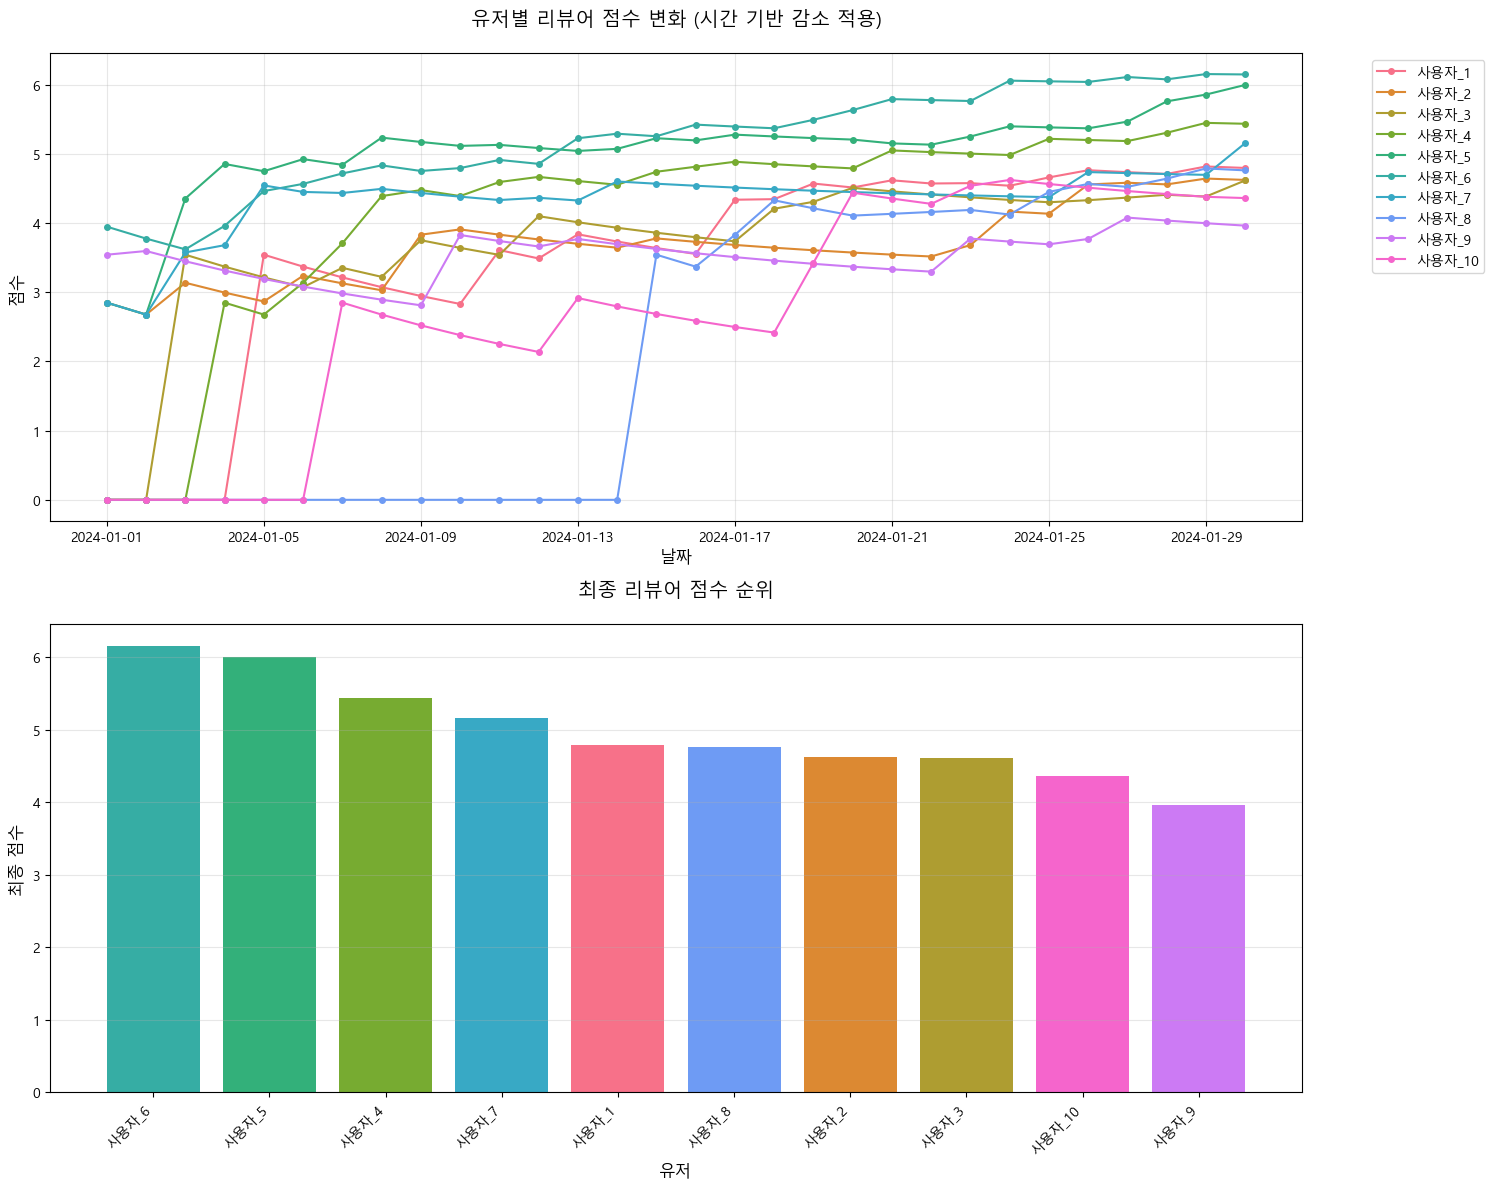

,date,user_id,score,num_reviews,weighted_helps,recency_score,weighted_best
0,2024-01-01,사용자_1,0.000000,0,0.000000,0.000000,0.000000
1,2024-01-01,사용자_2,2.849396,1,0.000000,0.904837,0.000000
2,2024-01-01,사용자_3,0.000000,0,0.000000,0.000000,0.000000
3,2024-01-01,사용자_4,0.000000,0,0.000000,0.000000,0.000000
4,2024-01-01,사용자_5,2.849396,1,0.000000,0.904837,0.000000
...,...,...,...,...,...,...,...
295,2024-01-30,사용자_6,6.147875,25,2.327855,0.026378,0.011292
296,2024-01-30,사용자_7,5.156030,15,1.372842,0.066529,0.000000
297,2024-01-30,사용자_8,4.761462,14,0.541492,0.133318,0.000000
298,2024-01-30,사용자_9,3.962739,7,0.667541,0.166113,0.000000


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def generate_user_data(n_users, n_days):
    """더 상세한 리뷰 데이터 생성"""
    users = []
    start_date = datetime(2024, 1, 1)
    
    for user_id in range(n_users):
        activity_level = np.random.uniform(0.3, 1.0)
        
        for day in range(n_days):
            current_date = start_date + timedelta(days=day)
            day_factor = 1 + (day / n_days) * 0.5
            
            # 일일 리뷰 수 생성
            daily_reviews = np.random.poisson(activity_level * day_factor * 0.5)
            
            if daily_reviews > 0:
                # 각 리뷰별 상세 정보 생성
                for _ in range(daily_reviews):
                    helps = max(0, int(np.random.normal(2 * activity_level * day_factor, 1)))
                    best_review = 1 if np.random.random() < 0.05 * activity_level else 0
                    
                    users.append({
                        'user_id': f'사용자_{user_id+1}',
                        'date': current_date,
                        'helps': helps,
                        'best_review': best_review,
                        'activity_level': activity_level
                    })
    
    return pd.DataFrame(users)

def calculate_time_decay_score(dates, current_date, lambda_decay=0.1):
    """시간 경과에 따른 감소 점수 계산"""
    days_passed = (current_date - dates).dt.days
    decay_scores = np.exp(-lambda_decay * days_passed)  # 경과 일수에 따른 지수 감소
    return decay_scores

def calculate_weighted_stats(group, current_date, lambda_decay=0.1):
    """그룹별 가중 통계 계산"""
    if len(group) == 0:
        return {
            'weighted_helps': 0,
            'weighted_best': 0,
            'recency_score': 0,
            'num_reviews': 0
        }
    
    # 시간 경과에 따른 가중치 계산
    time_weights = calculate_time_decay_score(group['date'], current_date, lambda_decay)
    normalized_weights = time_weights / time_weights.sum()
    
    # 최신성 점수는 가중치의 평균에 총 리뷰 수를 반영
    recency_factor = np.exp(-0.1 * len(group))  # 리뷰가 많을수록 약간의 패널티
    avg_recency = (time_weights.sum() / len(group)) * recency_factor
    
    stats = {
        'weighted_helps': (group['helps'] * normalized_weights).sum(),
        'weighted_best': (group['best_review'] * normalized_weights).sum(),
        'recency_score': avg_recency,
        'num_reviews': len(group)
    }
    return stats

def calculate_score(stats, weights):
    """최종 점수 계산"""
    return (
        weights['w_R'] * np.log1p(stats['num_reviews']) +
        weights['w_H'] * np.log1p(stats['weighted_helps']) +
        weights['w_T'] * stats['recency_score'] +
        weights['w_B'] * stats['weighted_best']
    )

# 데이터 생성 및 처리
n_users = 10
n_days = 30
df = generate_user_data(n_users, n_days)

# 날짜별 점수 계산
date_range = pd.date_range(df['date'].min(), df['date'].max())
scores_over_time = []

weights = {
    "w_R": 1.5,  # 리뷰 수 가중치
    "w_H": 1.0,  # 도움됨 가중치
    "w_T": 2.0,  # 최신성 가중치
    "w_B": 0.5   # 베스트 리뷰 가중치
}

for current_date in date_range:
    # 현재 날짜까지의 데이터만 선택
    current_data = df[df['date'] <= current_date]
    
    # 각 사용자별 통계 계산
    for user_id in df['user_id'].unique():
        user_data = current_data[current_data['user_id'] == user_id]
        stats = calculate_weighted_stats(user_data, current_date)
        score = calculate_score(stats, weights)
        
        scores_over_time.append({
            'date': current_date,
            'user_id': user_id,
            'score': score,
            'num_reviews': stats['num_reviews'],
            'weighted_helps': stats['weighted_helps'],
            'recency_score': stats['recency_score'],
            'weighted_best': stats['weighted_best']
        })

scores_df = pd.DataFrame(scores_over_time)

# 시각화
colors = sns.color_palette('husl', n_colors=n_users)
color_dict = dict(zip(df['user_id'].unique(), colors))

fig = plt.figure(figsize=(15, 12))

# 점수 변화 그래프
plt.subplot(2, 1, 1)
for user in df['user_id'].unique():
    user_scores = scores_df[scores_df['user_id'] == user]
    plt.plot(user_scores['date'], user_scores['score'], 
             marker='o', markersize=4, 
             color=color_dict[user], 
             label=user)

plt.title('유저별 리뷰어 점수 변화 (시간 기반 감소 적용)', pad=20, size=14)
plt.xlabel('날짜', size=12)
plt.ylabel('점수', size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 최종 점수 분포
plt.subplot(2, 1, 2)
final_scores = scores_df[scores_df['date'] == scores_df['date'].max()].sort_values('score', ascending=False)
bar_colors = [color_dict[user] for user in final_scores['user_id']]
bars = plt.bar(range(len(final_scores)), final_scores['score'], color=bar_colors)
plt.xticks(range(len(final_scores)), final_scores['user_id'], rotation=45, ha='right')
plt.title('최종 리뷰어 점수 순위', pad=20, size=14)
plt.xlabel('유저', size=12)
plt.ylabel('최종 점수', size=12)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

scores_df

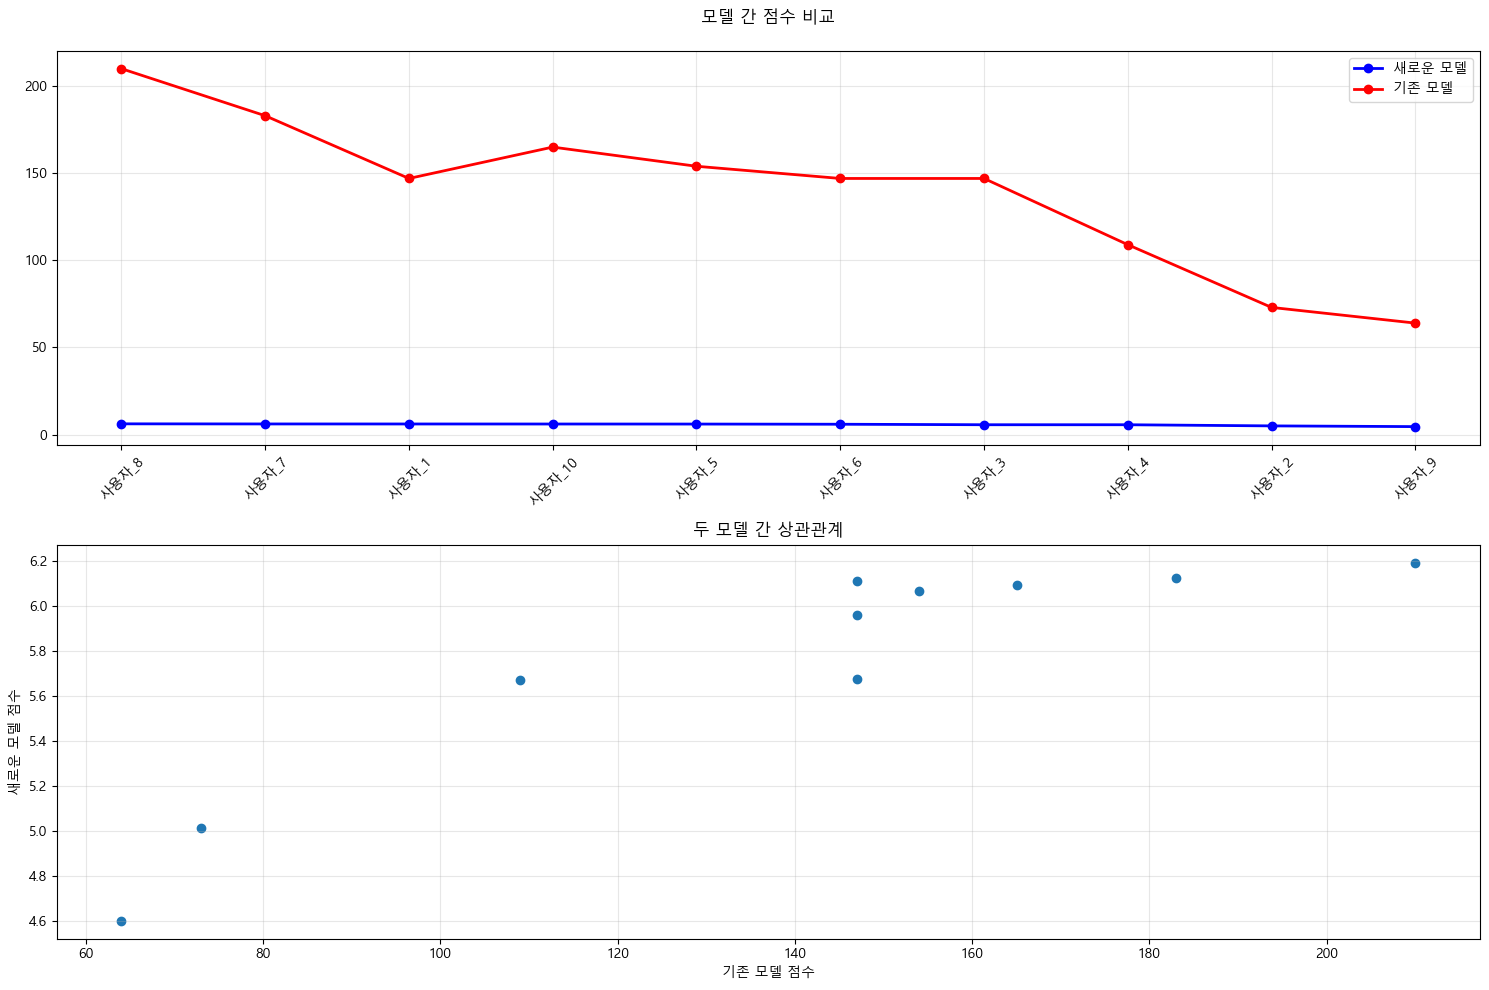


모델 비교 통계:
     유저ID  기존모델_점수  새모델_점수  리뷰수  베스트리뷰수  총도움됨
7   사용자_8    210.0    6.19   20       1    66
6   사용자_7    183.0    6.12   17       1    74
0   사용자_1    147.0    6.11   13       1    76
9  사용자_10    165.0    6.09   15       1    65
4   사용자_5    154.0    6.07   16       0    68
5   사용자_6    147.0    5.96   13       1    59
2   사용자_3    147.0    5.67   13       1    44
3   사용자_4    109.0    5.67   11       0    48
1   사용자_2     73.0    5.01    7       0    27
8   사용자_9     64.0    4.60    6       0    24

기존 모델의 한계점:

1. 단순 가산 방식의 한계:
   - 모든 리뷰가 동일한 기본 점수를 받음
   - 시간 경과에 따른 감소가 단계적이며 비연속적
   - 누적 점수가 계속 증가하여 신규 진입이 어려움

2. 최신성 반영의 한계:
   - 날짜별 가중치가 단순 구간으로 나뉘어 있음
   - 연속적인 시간 감소가 아닌 불연속적인 구간 적용
   - 오래된 리뷰의 영향력이 충분히 감소하지 않음

3. 품질 평가의 한계:
   - 리뷰의 품질(도움됨 수)이 점수에 반영되지 않음
   - 사진/동영상 첨부 여부만으로 품질 판단
   - 다른 사용자의 피드백이 제한적으로 반영됨

4. 참여 동기 부여의 한계:
   - 초기에 높은 점수를 얻기 어려움
   - 지속적인 참여 동기가 부족
   - 경쟁 요소가 제한적

5. 시스템 확장성의 한계:
   - 고정된 점수 체계로 인한 유연성 부족
   - 새로운 평가 요소 추가가 어려움
   - 시즌제 운영 등

In [78]:


print("\n기존 모델의 한계점:")
print("""
1. 단순 가산 방식의 한계:
   - 모든 리뷰가 동일한 기본 점수를 받음
   - 시간 경과에 따른 감소가 단계적이며 비연속적
   - 누적 점수가 계속 증가하여 신규 진입이 어려움

2. 최신성 반영의 한계:
   - 날짜별 가중치가 단순 구간으로 나뉘어 있음
   - 연속적인 시간 감소가 아닌 불연속적인 구간 적용
   - 오래된 리뷰의 영향력이 충분히 감소하지 않음

3. 품질 평가의 한계:
   - 리뷰의 품질(도움됨 수)이 점수에 반영되지 않음
   - 사진/동영상 첨부 여부만으로 품질 판단
   - 다른 사용자의 피드백이 제한적으로 반영됨

4. 참여 동기 부여의 한계:
   - 초기에 높은 점수를 얻기 어려움
   - 지속적인 참여 동기가 부족
   - 경쟁 요소가 제한적

5. 시스템 확장성의 한계:
   - 고정된 점수 체계로 인한 유연성 부족
   - 새로운 평가 요소 추가가 어려움
   - 시즌제 운영 등 다양한 이벤트 적용이 제한적
""")

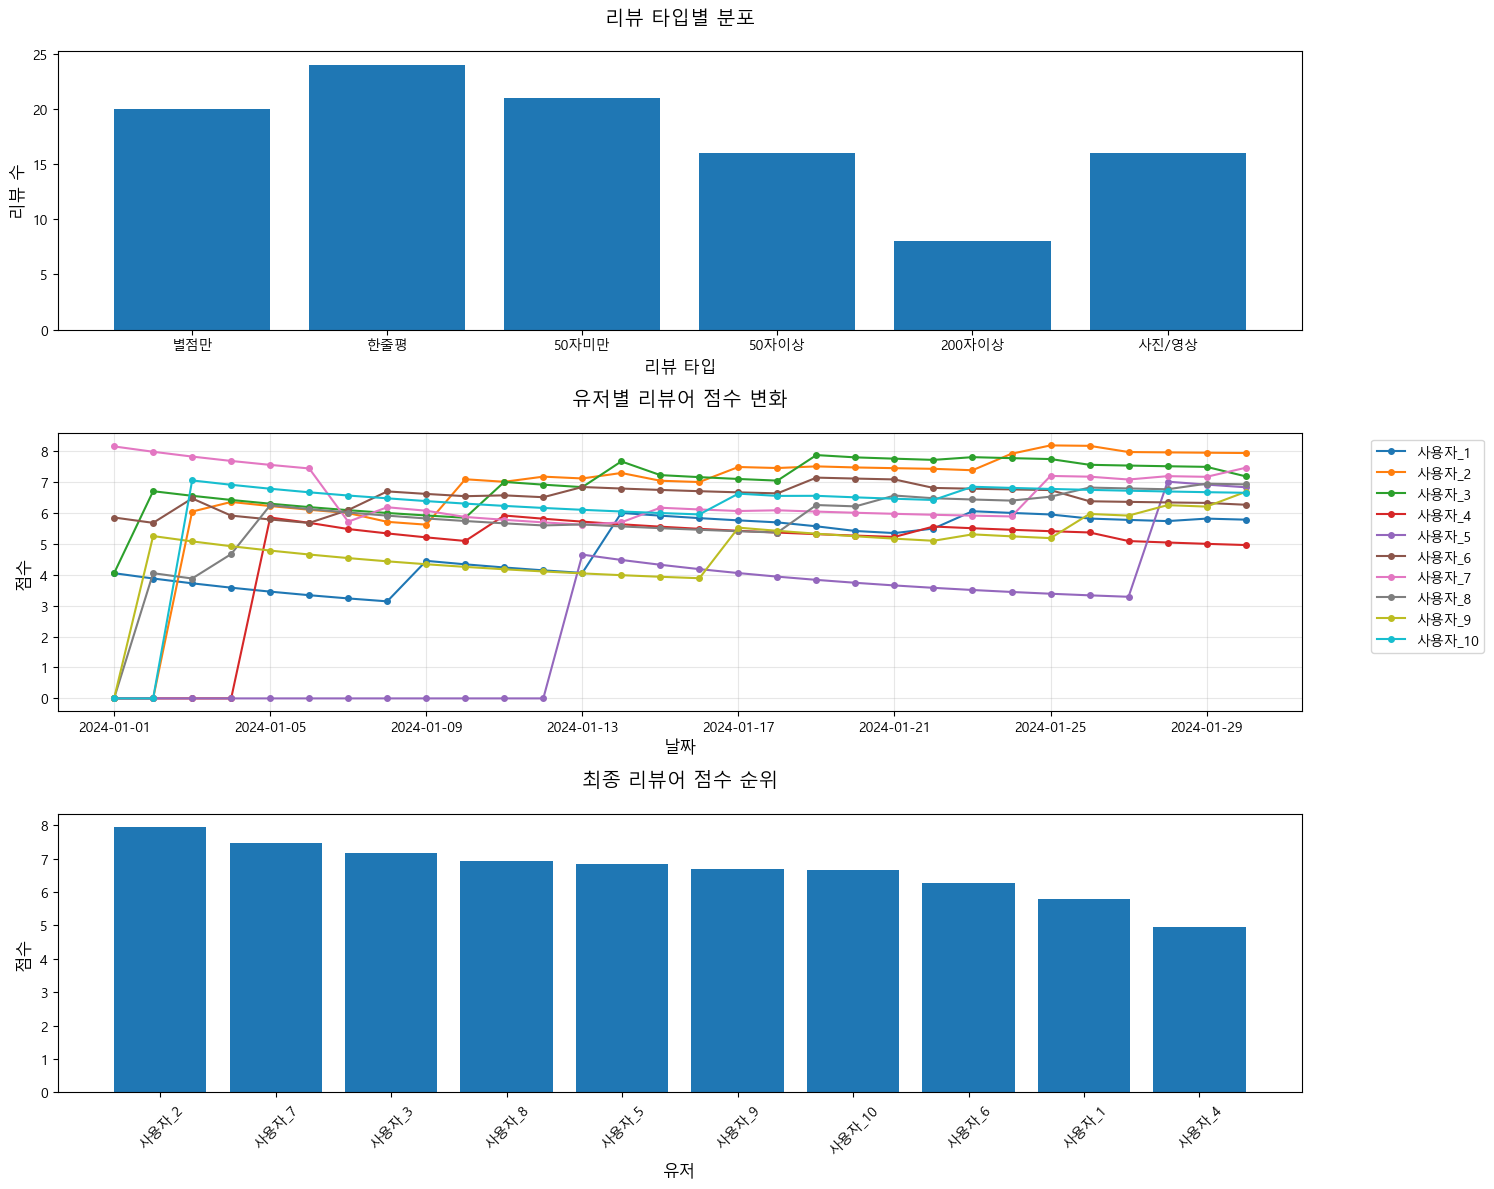


리뷰 품질 통계:
        리뷰 수  평균 도움됨  베스트리뷰 비율  평균 점수
별점만       20    0.10      0.00    1.0
한줄평       24    0.17      0.12    1.5
50자미만     21    0.57      0.10    2.0
50자이상     16    0.62      0.00    2.5
200자이상     8    0.38      0.00    3.0
사진/영상     16    1.06      0.00    3.5


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def determine_review_type(activity_level):
    """
    리뷰 타입 결정 (1~6)
    활동성이 높은 사용자일수록 더 높은 품질의 리뷰를 작성할 확률이 높음
    """
    # 기본 확률 분포 (베타 분포 기반)
    base_probs = np.array([0.3, 0.25, 0.2, 0.15, 0.07, 0.03])
    
    # 활동성에 따라 확률 조정
    shift = activity_level * 0.3  # 활동성이 높을수록 더 높은 품질의 리뷰 작성
    adjusted_probs = np.roll(base_probs, int(shift * 3))
    adjusted_probs = np.clip(adjusted_probs, 0.01, 0.5)  # 확률값 범위 제한
    adjusted_probs = adjusted_probs / adjusted_probs.sum()  # 정규화
    
    # 리뷰 타입 선택 (1~6)
    review_type = np.random.choice(6, p=adjusted_probs) + 1
    
    # 사진/영상 리뷰 추가 확률 (타입 6)
    if review_type != 6 and np.random.random() < activity_level * 0.2:
        review_type = 6
    
    return review_type

def get_review_score(review_type):
    """리뷰 타입별 기본 점수"""
    base_scores = {
        1: 1,    # 별점만
        2: 1.5,    # 한줄평
        3: 2,    # 50자 미만
        4: 2.5,    # 50자 이상
        5: 3,    # 200자 이상
        6: 3.5    # 사진/영상
    }
    return base_scores[review_type]

def generate_user_data(n_users, n_days):
    """더 상세한 리뷰 데이터 생성"""
    users = []
    start_date = datetime(2024, 1, 1)
    
    for user_id in range(n_users):
        activity_level = np.random.uniform(0.3, 1.0)
        
        for day in range(n_days):
            current_date = start_date + timedelta(days=day)
            day_factor = 1 + (day / n_days) * 0.5
            
            # 일일 리뷰 수 생성 (포아송 분포)
            daily_reviews = np.random.poisson(activity_level * day_factor * 0.5)
            
            if daily_reviews > 0:
                for _ in range(daily_reviews):
                    # 리뷰 타입 결정
                    review_type = determine_review_type(activity_level)
                    review_score = get_review_score(review_type)
                    
                    # 도움됨 수는 리뷰 품질과 연관되도록 설정
                    helps = max(0, int(np.random.normal( ## -> 팩터에 따른 도움됨 수 시뮬레이션
                        review_score * activity_level * day_factor * 0.5, # <- 평균. 도움됨 점수. ex) 사진 리뷰 * 높은 활동성 * 최근 작성
                        review_score * 0.3 # <- 표준편차
                    )))
                    
                    # 베스트 리뷰 선정 확률도 리뷰 품질과 연관되도록 설정
                    best_review_prob = 0.02 * review_score * activity_level
                    best_review = 1 if np.random.random() < best_review_prob else 0
                    
                    users.append({
                        'user_id': f'사용자_{user_id+1}',
                        'date': current_date,
                        'review_type': review_type,
                        'review_score': review_score,
                        'helps': helps,
                        'best_review': best_review,
                        'activity_level': activity_level
                    })
    
    return pd.DataFrame(users)

def calculate_weighted_stats(group, current_date, lambda_decay=0.1):
    """그룹별 가중 통계 계산"""
    if len(group) == 0:
        return {
            'weighted_helps': 0,
            'weighted_best': 0,
            'weighted_review_score': 0,
            'recency_score': 0,
            'num_reviews': 0
        }
    
    time_weights = calculate_time_decay_score(group['date'], current_date, lambda_decay)
    normalized_weights = time_weights / time_weights.sum()
    
    recency_factor = np.exp(-0.1 * len(group))
    avg_recency = (time_weights.sum() / len(group)) * recency_factor
    
    return {
        'weighted_helps': (group['helps'] * normalized_weights).sum(),
        'weighted_best': (group['best_review'] * normalized_weights).sum(),
        'weighted_review_score': (group['review_score'] * normalized_weights).sum(),
        'recency_score': avg_recency,
        'num_reviews': len(group)
    }

def calculate_score(stats, weights):
    """최종 점수 계산"""
    return (
        weights['w_R'] * np.log1p(stats['num_reviews']) +
        weights['w_H'] * np.log1p(stats['weighted_helps']) +
        weights['w_T'] * stats['recency_score'] +
        weights['w_B'] * stats['weighted_best'] +
        weights['w_Q'] * stats['weighted_review_score']  # 리뷰 품질 점수 추가
    )

# 데이터 생성 및 처리
n_users = 10
n_days = 30
df = generate_user_data(n_users, n_days)

# 가중치 설정
weights = {
    "w_R": 1.5,  # 리뷰 수 가중치
    "w_H": 1.0,  # 도움됨 가중치
    "w_T": 2.0,  # 최신성 가중치
    "w_B": 0.5,  # 베스트 리뷰 가중치
    "w_Q": 1.2   # 리뷰 품질 가중치
}

### 시각화

# 점수 계산 및 시각화
date_range = pd.date_range(df['date'].min(), df['date'].max())
scores_over_time = []

for current_date in date_range:
    current_data = df[df['date'] <= current_date]
    
    for user_id in df['user_id'].unique():
        user_data = current_data[current_data['user_id'] == user_id]
        stats = calculate_weighted_stats(user_data, current_date)
        score = calculate_score(stats, weights)
        
        scores_over_time.append({
            'date': current_date,
            'user_id': user_id,
            'score': score,
            'num_reviews': stats['num_reviews'],
            'weighted_helps': stats['weighted_helps'],
            'weighted_review_score': stats['weighted_review_score'],
            'recency_score': stats['recency_score'],
            'weighted_best': stats['weighted_best']
        })

scores_df = pd.DataFrame(scores_over_time)

# 리뷰 타입 분포 시각화
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
review_type_counts = df['review_type'].value_counts().sort_index()
plt.bar(range(1, 7), review_type_counts)
plt.title('리뷰 타입별 분포', pad=20, size=14)
plt.xlabel('리뷰 타입', size=12)
plt.ylabel('리뷰 수', size=12)
plt.xticks(range(1, 7), ['별점만', '한줄평', '50자미만', '50자이상', '200자이상', '사진/영상'])

# 점수 변화 그래프
plt.subplot(3, 1, 2)
for user in df['user_id'].unique():
    user_scores = scores_df[scores_df['user_id'] == user]
    plt.plot(user_scores['date'], user_scores['score'], 
             marker='o', markersize=4, 
             label=user)

plt.title('유저별 리뷰어 점수 변화', pad=20, size=14)
plt.xlabel('날짜', size=12)
plt.ylabel('점수', size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 최종 통계
plt.subplot(3, 1, 3)
final_date = scores_df['date'].max()
final_stats = scores_df[scores_df['date'] == final_date].sort_values('score', ascending=False)
plt.bar(range(len(final_stats)), final_stats['score'])
plt.xticks(range(len(final_stats)), final_stats['user_id'], rotation=45)
plt.title('최종 리뷰어 점수 순위', pad=20, size=14)
plt.xlabel('유저', size=12)
plt.ylabel('점수', size=12)

plt.tight_layout()
plt.show()

# 최종 통계 출력
print("\n리뷰 품질 통계:")
quality_stats = df.groupby('review_type').agg({
    'helps': ['count', 'mean'],
    'best_review': 'mean',
    'review_score': 'mean'
}).round(2)
quality_stats.columns = ['리뷰 수', '평균 도움됨', '베스트리뷰 비율', '평균 점수']
quality_stats.index = ['별점만', '한줄평', '50자미만', '50자이상', '200자이상', '사진/영상']
print(quality_stats)

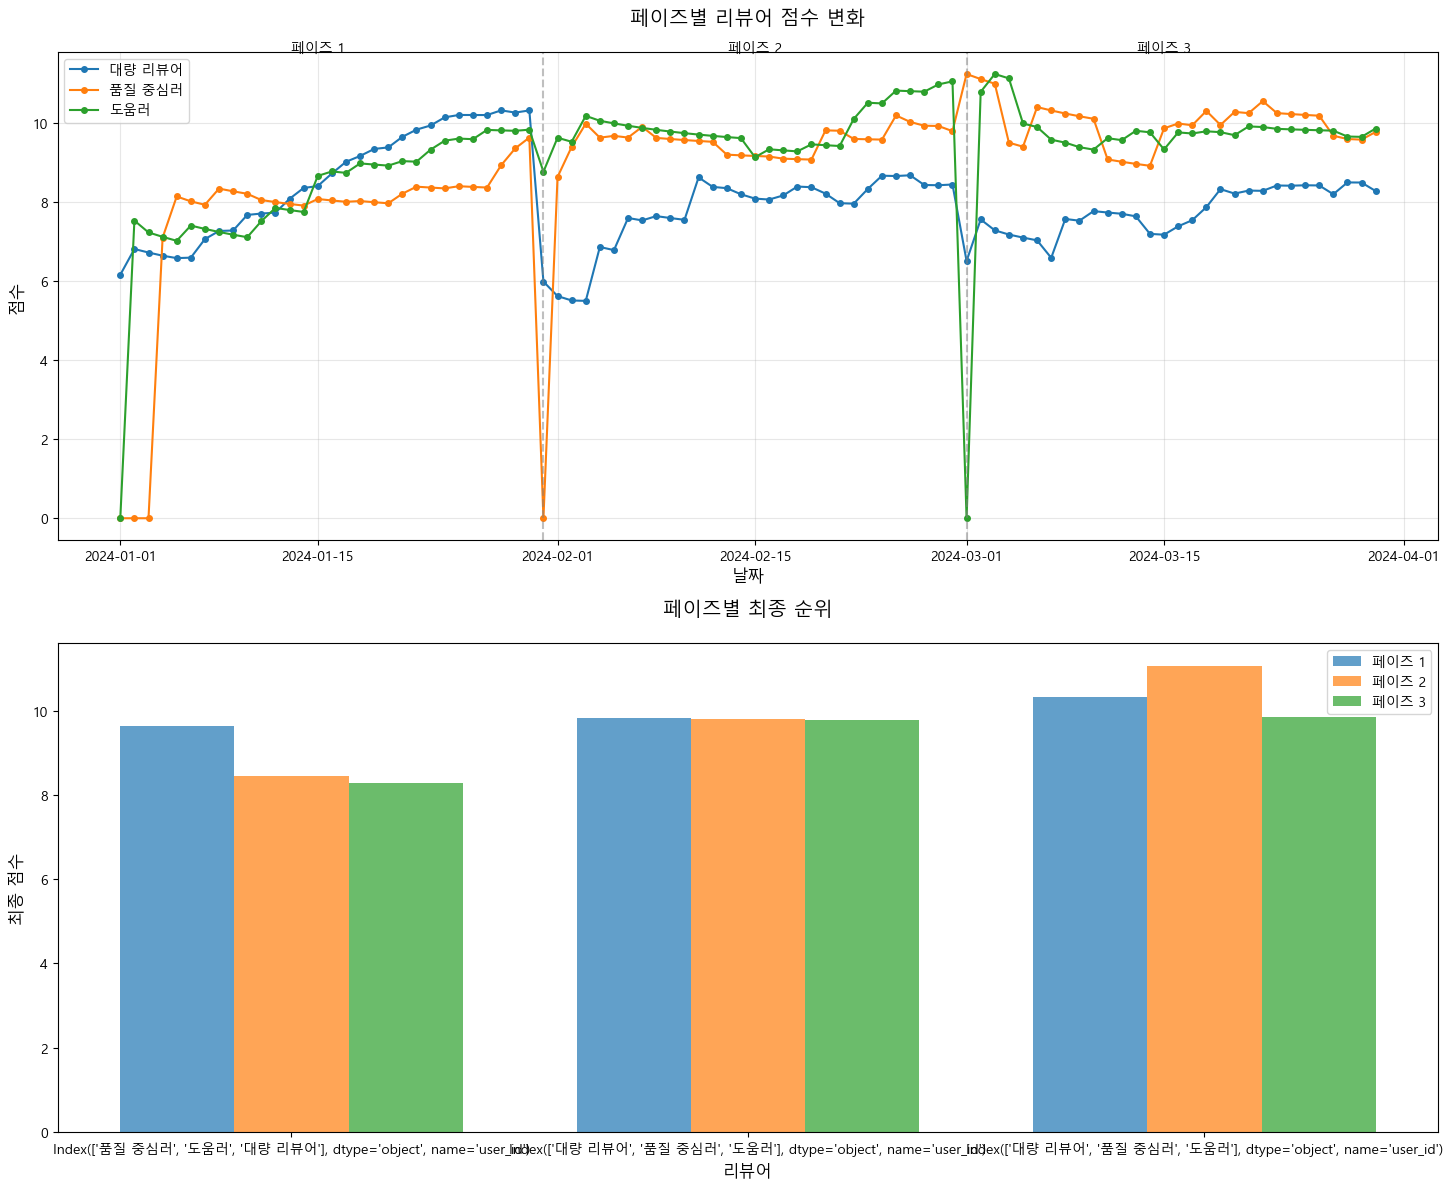


페이즈별 리뷰어 통계:

페이즈 1 통계:
         리뷰 수  총 도움됨  베스트 리뷰 수  평균 리뷰 점수
user_id                                 
대량 리뷰어     44     85         0      2.18
도움러        17    122         0      2.74
품질 중심러     18     88         2      2.64

페이즈 2 통계:
         리뷰 수  총 도움됨  베스트 리뷰 수  평균 리뷰 점수
user_id                                 
대량 리뷰어     24     49         1      1.94
도움러        17    125         0      2.79
품질 중심러     21    100         0      2.45

페이즈 3 통계:
         리뷰 수  총 도움됨  베스트 리뷰 수  평균 리뷰 점수
user_id                                 
대량 리뷰어     30    100         0      2.10
도움러        20    180         0      2.38
품질 중심러     15    125         0      2.70


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

class ReviewerPersona:
    """리뷰어 페르소나 정의"""
    def __init__(self, 
                 name,
                 activity_level,
                 quality_preference,
                 consistency_level,
                 helpful_focus):
        self.name = name
        self.activity_level = activity_level  # 활동량 (0~1)
        self.quality_preference = quality_preference  # 고품질 리뷰 선호도 (0~1)
        self.consistency_level = consistency_level  # 지속성 (0~1)
        self.helpful_focus = helpful_focus  # 도움되는 리뷰 작성 집중도 (0~1)

    def generate_review_type(self, day):
        """페르소나별 리뷰 타입 생성 로직"""
        # 기본 확률 분포
        base_probs = np.array([0.3, 0.25, 0.2, 0.15, 0.07, 0.03])
        
        # 품질 선호도에 따른 확률 조정
        shift = self.quality_preference * 0.5
        adjusted_probs = np.roll(base_probs, int(shift * 4))
        
        # 시간에 따른 일관성 반영
        consistency_factor = np.exp(-0.01 * day * (1 - self.consistency_level))
        adjusted_probs = adjusted_probs * consistency_factor
        
        adjusted_probs = np.clip(adjusted_probs, 0.01, 0.5)
        adjusted_probs = adjusted_probs / adjusted_probs.sum()
        
        review_type = np.random.choice(6, p=adjusted_probs) + 1
        
        # 사진/동영상 리뷰 추가 확률
        if review_type != 6 and np.random.random() < self.quality_preference * 0.3:
            review_type = 6
            
        return review_type

    def daily_review_count(self, day, phase):
        """일일 리뷰 수 생성"""
        base_rate = self.activity_level * (1 + 0.2 * np.sin(day/7 * np.pi))  # 주간 패턴
        consistency = np.exp(-0.01 * day * (1 - self.consistency_level))  # 시간에 따른 감소
        
        # 페이즈별 특성 반영
        phase_factor = 1.0
        if phase == 1 and self.activity_level > 0.7:  # 초기에는 많은 리뷰 선호
            phase_factor = 1.3
        elif phase == 2 and self.quality_preference > 0.7:  # 중기에는 품질 중시
            phase_factor = 1.2
        elif phase == 3 and self.helpful_focus > 0.7:  # 후기에는 도움되는 리뷰 중시
            phase_factor = 1.1
            
        return np.random.poisson(base_rate * consistency * phase_factor)

def simulate_reviews(personas, n_days_per_phase=30):
    """페이즈별 리뷰 시뮬레이션"""
    reviews = []
    start_date = datetime(2024, 1, 1)
    total_days = n_days_per_phase * 3
    
    for day in range(total_days):
        current_date = start_date + timedelta(days=day)
        phase = (day // n_days_per_phase) + 1
        
        for persona in personas:
            daily_reviews = persona.daily_review_count(day, phase)
            
            for _ in range(daily_reviews):
                review_type = persona.generate_review_type(day)
                review_score = get_review_score(review_type)
                
                # 도움됨 수 계산 (페이즈별 특성 반영)
                base_helpful = review_score * persona.helpful_focus
                if phase == 3:  # 페이즈 3에서는 도움됨 수가 더 중요
                    base_helpful *= 1.5
                
                helps = max(0, int(np.random.normal(
                    base_helpful * 3,
                    review_score * 0.3
                )))
                
                best_review_prob = 0.02 * review_score * persona.quality_preference
                if phase == 2:  # 페이즈 2에서는 고품질 리뷰가 더 중요
                    best_review_prob *= 1.5
                    
                best_review = 1 if np.random.random() < best_review_prob else 0
                
                reviews.append({
                    'user_id': persona.name,
                    'date': current_date,
                    'phase': phase,
                    'review_type': review_type, 
                    'review_score': review_score,
                    'helps': helps,
                    'best_review': best_review
                })
    
    return pd.DataFrame(reviews)

# 페르소나 정의
personas = [
    ReviewerPersona(
        name="대량 리뷰어",
        activity_level=0.9,       # 높은 활동량
        quality_preference=0.3,   # 낮은 품질 선호도
        consistency_level=0.7,    # 중간 수준의 지속성
        helpful_focus=0.4         # 낮은 도움됨 집중도
    ),
    ReviewerPersona(
        name="품질 중심러",
        activity_level=0.6,       # 중간 활동량
        quality_preference=0.9,   # 높은 품질 선호도
        consistency_level=0.9,    # 높은 지속성
        helpful_focus=0.7         # 중상 도움됨 집중도
    ),
    ReviewerPersona(
        name="도움러",
        activity_level=0.7,       # 중상 활동량
        quality_preference=0.7,   # 중상 품질 선호도
        consistency_level=0.8,    # 중상 지속성
        helpful_focus=0.9         # 높은 도움됨 집중도
    )
]

# 페이즈별 가중치 설정
phase_weights = {
    1: {  # 초기: 리뷰 수 중심
        "w_R": 2.0,  # 리뷰 수 가중치 증가
        "w_H": 0.8,  # 도움됨 가중치 감소
        "w_T": 1.5,  # 최신성 가중치
        "w_B": 0.3,  # 베스트 리뷰 가중치 감소
        "w_Q": 0.8   # 품질 가중치 감소
    },
    2: {  # 중기: 품질 중심
        "w_R": 1.2,  # 리뷰 수 가중치
        "w_H": 1.0,  # 도움됨 가중치
        "w_T": 1.5,  # 최신성 가중치
        "w_B": 0.8,  # 베스트 리뷰 가중치
        "w_Q": 1.8   # 품질 가중치 증가
    },
    3: {  # 후기: 도움됨 중심
        "w_R": 0.8,  # 리뷰 수 가중치 감소
        "w_H": 2.0,  # 도움됨 가중치 증가
        "w_T": 1.5,  # 최신성 가중치
        "w_B": 1.0,  # 베스트 리뷰 가중치
        "w_Q": 1.2   # 품질 가중치
    }
}

# 시뮬레이션 실행
df = simulate_reviews(personas)

# 페이즈별 점수 계산
scores = []
for phase in [1, 2, 3]:
    phase_data = df[df['phase'] == phase]
    current_weights = phase_weights[phase]
    
    for current_date in pd.date_range(phase_data['date'].min(), phase_data['date'].max()):
        current_data = phase_data[phase_data['date'] <= current_date]
        
        for persona in personas:
            user_data = current_data[current_data['user_id'] == persona.name]
            stats = calculate_weighted_stats(user_data, current_date)
            score = calculate_score(stats, current_weights)
            
            scores.append({
                'date': current_date,
                'phase': phase,
                'user_id': persona.name,
                'score': score,
                'num_reviews': stats['num_reviews'],
                'weighted_helps': stats['weighted_helps'],
                'weighted_review_score': stats['weighted_review_score']
            })

scores_df = pd.DataFrame(scores)

# 시각화
plt.figure(figsize=(15, 12))

# 페이즈별 점수 변화
plt.subplot(2, 1, 1)
for persona in personas:
    user_scores = scores_df[scores_df['user_id'] == persona.name]
    plt.plot(user_scores['date'], user_scores['score'], 
             label=persona.name, marker='o', markersize=4)

plt.axvline(x=pd.Timestamp('2024-01-31'), color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=pd.Timestamp('2024-03-01'), color='gray', linestyle='--', alpha=0.5)
plt.text(pd.Timestamp('2024-01-15'), plt.ylim()[1], '페이즈 1', ha='center')
plt.text(pd.Timestamp('2024-02-15'), plt.ylim()[1], '페이즈 2', ha='center')
plt.text(pd.Timestamp('2024-03-15'), plt.ylim()[1], '페이즈 3', ha='center')

plt.title('페이즈별 리뷰어 점수 변화', pad=20, size=14)
plt.xlabel('날짜', size=12)
plt.ylabel('점수', size=12)
plt.legend()
plt.grid(True, alpha=0.3)

# 페이즈별 순위 변화
plt.subplot(2, 1, 2)
phase_rankings = []
for phase in [1, 2, 3]:
    phase_end = scores_df[scores_df['phase'] == phase].groupby('user_id')['score'].last()
    phase_rankings.append(phase_end.sort_values(ascending=True))

x = range(len(personas))
width = 0.25
plt.bar([i - width for i in x], phase_rankings[0], width, label='페이즈 1', alpha=0.7)
plt.bar([i for i in x], phase_rankings[1], width, label='페이즈 2', alpha=0.7)
plt.bar([i + width for i in x], phase_rankings[2], width, label='페이즈 3', alpha=0.7)

plt.title('페이즈별 최종 순위', pad=20, size=14)
plt.xlabel('리뷰어', size=12)
plt.ylabel('최종 점수', size=12)
plt.xticks(x, [r.index for r in phase_rankings])
plt.legend()

plt.tight_layout()
plt.show()

# 통계 출력
print("\n페이즈별 리뷰어 통계:")
for phase in [1, 2, 3]:
    print(f"\n페이즈 {phase} 통계:")
    phase_data = df[df['phase'] == phase].groupby('user_id').agg({
        'review_type': 'count',
        'helps': 'sum',
        'best_review': 'sum',
        'review_score': 'mean'
    }).round(2)
    phase_data.columns = ['리뷰 수', '총 도움됨', '베스트 리뷰 수', '평균 리뷰 점수']
    print(phase_data)